In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [2]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 100,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 100,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 100,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 100,5)

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.524  buffer =  0.02524
radius_vspp_wind km =  0.8410000000000001  buffer =  0.00841
radius_spp_solar km =  1.3820000000000001  buffer =  0.01382
radius_vspp_solar km =  0.461  buffer =  0.00461


In [3]:
xr_out = xr.open_dataset('Output\\xr_output.nc')
print(xr_out)
print("cap_SPP_wind = ",xr_out['cap_SPP_wind'].sum())
print("cap_VSPP_wind = ",xr_out['cap_VSPP_wind'].sum())
print("cap_SPP_solar = ",xr_out['cap_SPP_solar'].sum())
print("cap_VSPP_solar = ",xr_out['cap_VSPP_solar'].sum())

<xarray.Dataset>
Dimensions:         (lat: 1070, lon: 597)
Coordinates:
  * lat             (lat) float64 5.621 5.635 5.649 5.663 ... 20.44 20.45 20.46
  * lon             (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables: (12/15)
    SI_Solar        (lat, lon) float64 ...
    SI_Wind         (lat, lon) float64 ...
    A_BGEC          (lat, lon) float64 ...
    A_Biomass       (lat, lon) float64 ...
    A_BGWW          (lat, lon) float64 ...
    A_MSW           (lat, lon) float64 ...
    ...              ...
    ADM1_EN         (lat, lon) object ...
    region          (lat, lon) object ...
    cap_SPP_wind    (lat, lon) float64 ...
    cap_VSPP_wind   (lat, lon) float64 ...
    cap_SPP_solar   (lat, lon) float64 ...
    cap_VSPP_solar  (lat, lon) float64 ...
cap_SPP_wind =  <xarray.DataArray 'cap_SPP_wind' ()>
array(26847.40526199)
cap_VSPP_wind =  <xarray.DataArray 'cap_VSPP_wind' ()>
array(332.31501007)
cap_SPP_solar =  <xarray.DataArray 'cap_SPP_solar' ()>


In [4]:
df_wind = xr_out.to_dataframe()
df_wind.reset_index(inplace=True)
df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
df_wind.crs = {'init': 'epsg:4326'}
print(len(df_wind))
for i,c in enumerate(df_wind.columns):
    if c not in (['lon','lat','SI_Wind','region','ADM1_EN','cap_SPP_wind','cap_VSPP_wind','geometry']):
        df_wind = df_wind.drop(columns=c)

df_wind_spp = df_wind.drop(columns='cap_VSPP_wind')
df_wind_spp = df_wind_spp.loc[df_wind_spp['cap_SPP_wind'] > 0]
df_wind_spp.reset_index(inplace=True,drop=False)
df_wind_spp.crs = {'init': 'epsg:4326'}
df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind)
df_wind_spp = df_wind_spp.set_geometry('buffer')

df_wind_vspp = df_wind.drop(columns='cap_SPP_wind')
df_wind_vspp = df_wind_vspp.loc[df_wind_vspp['cap_VSPP_wind'] > 0]
df_wind_vspp.reset_index(inplace=True,drop=False)
df_wind_vspp.crs = {'init': 'epsg:4326'}
df_wind_vspp['buffer'] = df_wind_vspp['geometry'].buffer(radius_vspp_wind)
df_wind_vspp = df_wind_vspp.set_geometry('buffer')

df_wind_spp.to_csv('Output\\Output_wind_spp.csv',index=False,encoding="utf-8-sig")
df_wind_vspp.to_csv('Output\\Output_wind_vspp.csv',index=False,encoding="utf-8-sig")

print(df_wind_spp)
print(df_wind_vspp)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638790


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_15368\2231694598.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes

      index        lat         lon   SI_Wind    ADM1_EN region  cap_SPP_wind  \
0     32511   6.370833  101.143056  0.761321       Yala     R3     19.035002   
1     33698   6.398611  101.045833  0.714671       Yala     R3     30.375000   
2     34287   6.412500  100.934722  0.596568       Yala     R3     17.010000   
3     34898   6.426389  101.129167  0.800833       Yala     R3     34.424999   
4     36675   6.468056  100.934722  0.306389       Yala     R3     21.059999   
..      ...        ...         ...       ...        ...    ...           ...   
349  540136  18.176389  103.573611  1.995923  Bueng Kan     R2     76.139999   
350  540720  18.190278  103.393056  1.970207  Bueng Kan     R2     85.860001   
351  540724  18.190278  103.448611  1.980480  Bueng Kan     R2     87.075005   
352  541909  18.218056  103.323611  1.845340  Bueng Kan     R2     79.379997   
353  544298  18.273611  103.337500  1.939610  Bueng Kan     R2     87.480003   

                       geometry  \
0   

In [5]:
df_solar = xr_out.to_dataframe()
df_solar.reset_index(inplace=True)
df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
df_solar.crs = {'init': 'epsg:4326'}
print(len(df_solar))
for i,c in enumerate(df_solar.columns):
    if c not in (['lon','lat','SI_Solar','region','ADM1_EN','cap_SPP_solar','cap_VSPP_solar','geometry']):
        df_solar = df_solar.drop(columns=c)

df_solar_spp = df_solar.drop(columns='cap_VSPP_solar')
df_solar_spp = df_solar_spp.loc[df_solar_spp['cap_SPP_solar'] > 0]
df_solar_spp.reset_index(inplace=True,drop=False)
df_solar_spp.crs = {'init': 'epsg:4326'}
df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar)
df_solar_spp = df_solar_spp.set_geometry('buffer')

df_solar_vspp = df_solar.drop(columns='cap_SPP_solar')
df_solar_vspp = df_solar_vspp.loc[df_solar_vspp['cap_VSPP_solar'] > 0]
df_solar_vspp.reset_index(inplace=True,drop=False)
df_solar_vspp.crs = {'init': 'epsg:4326'}
df_solar_vspp['buffer'] = df_solar_vspp['geometry'].buffer(radius_vspp_solar)
df_solar_vspp = df_solar_vspp.set_geometry('buffer')


df_solar_spp.to_csv('Output\\Output_solar_spp.csv',index=False,encoding="utf-8-sig")
df_solar_vspp.to_csv('Output\\Output_solar_vspp.csv',index=False,encoding="utf-8-sig")

print(df_solar_spp)
print(df_solar_vspp)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638790


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_15368\2131616170.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order chan

       index        lat         lon  SI_Solar     ADM1_EN region  \
0      17043   6.009722  101.893056  2.417830  Narathiwat     R3   
1      17046   6.009722  101.934722  1.231596  Narathiwat     R3   
2      21224   6.106944  101.920833  0.095821  Narathiwat     R3   
3      22999   6.148611  101.698611  1.050485  Narathiwat     R3   
4      24820   6.190278  102.115278  1.461403  Narathiwat     R3   
...      ...        ...         ...       ...         ...    ...   
4012  545483  18.301389  103.212500  0.878368   Bueng Kan     R2   
4013  548250  18.370833  100.184722  1.236925       Phrae     R4   
4014  550637  18.426389  100.170833  0.606889       Phrae     R4   
4015  554221  18.509722  100.198611  0.072037       Phrae     R4   
4016  559038  18.620833  100.768056  0.798426         Nan     R4   

      cap_SPP_solar                    geometry  \
0         90.000000   POINT (101.89306 6.00972)   
1         78.300003   POINT (101.93472 6.00972)   
2         68.850006   POINT (1

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  27179.720272064034
total SPP wind capacity =  26847.405261993204
total VSPP wind capacity =  332.31501007083006


<Axes: >

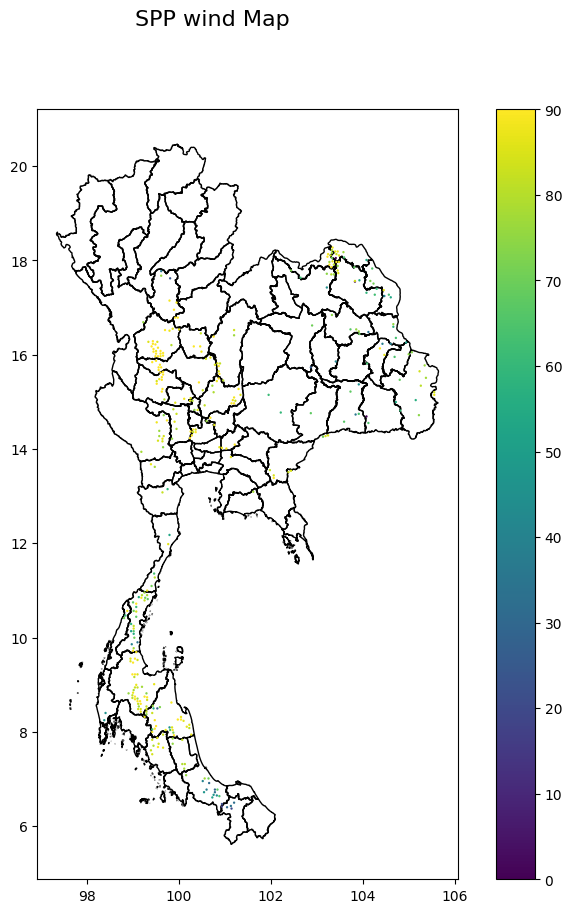

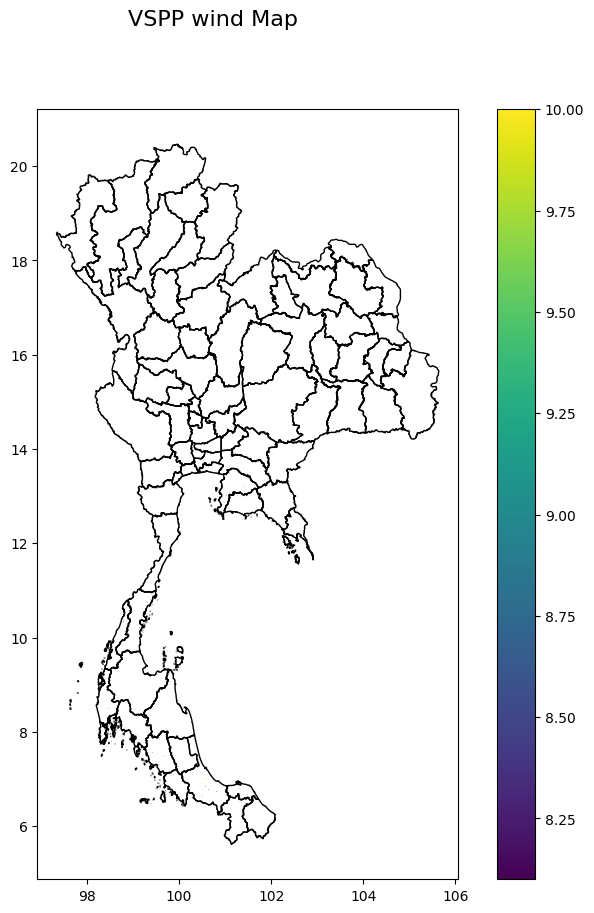

In [6]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].sum() + df_wind_vspp['cap_VSPP_wind'].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SPP wind Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_wind_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP wind Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_wind_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_wind')


total solar capacity =  388921.607175354
total SPP solar capacity =  311295.1565876053
total VSPP solar capacity =  77626.45058774867


<Axes: >

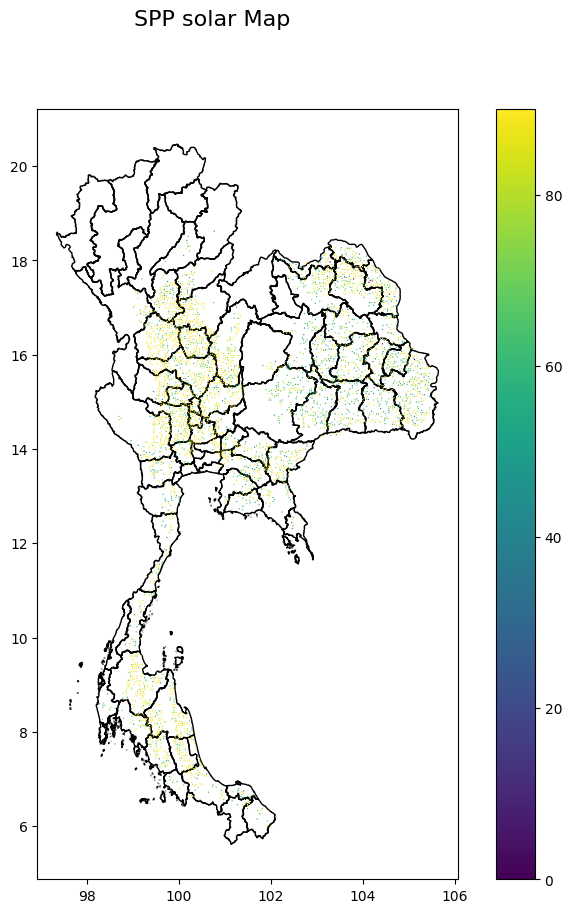

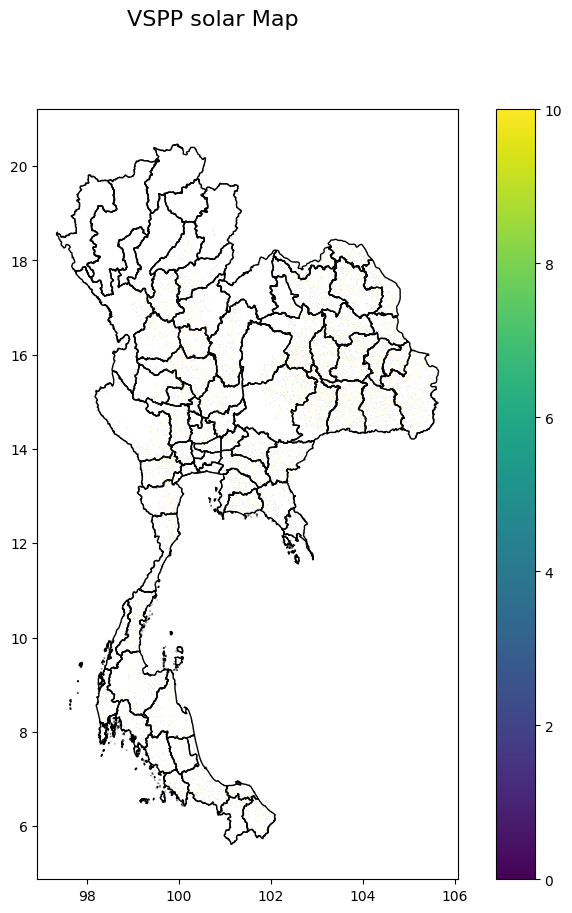

In [7]:
print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].sum() + df_solar_vspp['cap_VSPP_solar'].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('SPP solar Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_solar_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_solar')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP solar Map', fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
df_solar_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_solar')

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


total wind capacity =  360.4500045776
total SPP wind capacity =  360.4500045776
total VSPP wind capacity =  0.0
total solar capacity =  7720.90022456678
total SPP solar capacity =  5312.700206756899
total VSPP solar capacity =  2408.20001780988


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


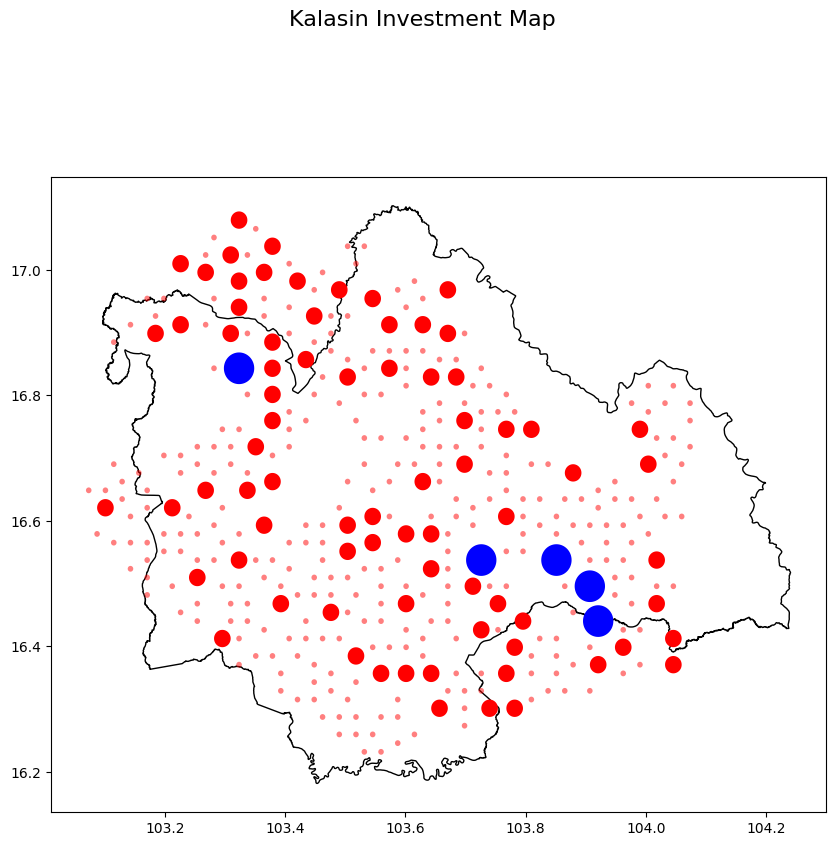

In [9]:
province = 'Kalasin'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_EN'] == province]
bound = specificarea.unary_union.bounds

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum() + df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())

print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum() + df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province + ' Investment Map ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind_spp.loc[df_wind_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind',color = 'blue')
    df_wind_vspp.loc[df_wind_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 2,column = 'cap_VSPP_wind',color = 'blue',alpha = 0.5)
except:
    None
try:
    df_solar_spp.loc[df_solar_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_SPP_solar',color = 'red')
    df_solar_vspp.loc[df_solar_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 4,column = 'cap_VSPP_solar',color = 'red',alpha = 0.5)
except:
    None